In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback
import sys
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
import re
from urllib.request import urlopen
import tensorflow as tf

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU') if tf.test.is_gpu_available() else tf.config.experimental.list_physical_devices('CPU')
devices

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.experimental.set_memory_growth(devices[0],True)

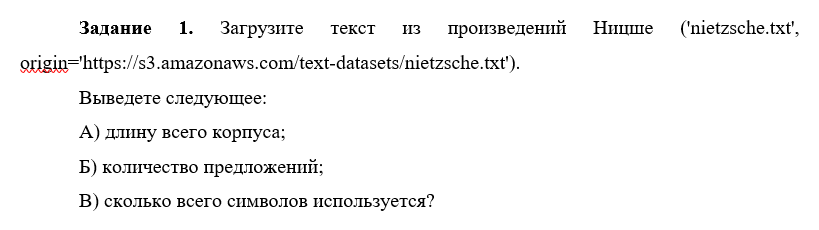
### Задание 1.

In [ ]:
data = urlopen('https://s3.amazonaws.com/text-datasets/nietzsche.txt')
nietzsche = ''
for line in data:
    nietzsche += line.decode('utf-8')

In [ ]:
nietzsche = nietzsche.replace('\n\n', '.').replace('\n', ' ')
nietzsche[:100]

'PREFACE. SUPPOSING that Truth is a woman--what then? Is there not ground for suspecting that all phi'

In [ ]:
niet_sentences = [sentence.lstrip() for sentence in re.split(r'[.!?]', nietzsche)]
niet_sentences[:5]

['PREFACE',
 'SUPPOSING that Truth is a woman--what then',
 'Is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women--that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to Truth, have been unskilled and unseemly methods for winning a woman',
 'Certainly she has never allowed herself to be won; and at present every kind of dogma stands with sad and discouraged mien--IF, indeed, it stands at all',
 'For there are scoffers who maintain that it has fallen, that all dogma lies on the ground--nay more, that it is at its last gasp']

In [ ]:
unique_symbols = list(set(nietzsche))
unique_symbols[:5]

['u', 'S', 'w', 'U', '5']

In [ ]:
print(f'Длина всего корпуса: {len(nietzsche)},\nВсего предложений: {len(niet_sentences)},\nУникальных символов используется: {len(unique_symbols)}')

Длина всего корпуса: 600178,
Всего предложений: 4312,
Уникальных символов используется: 83


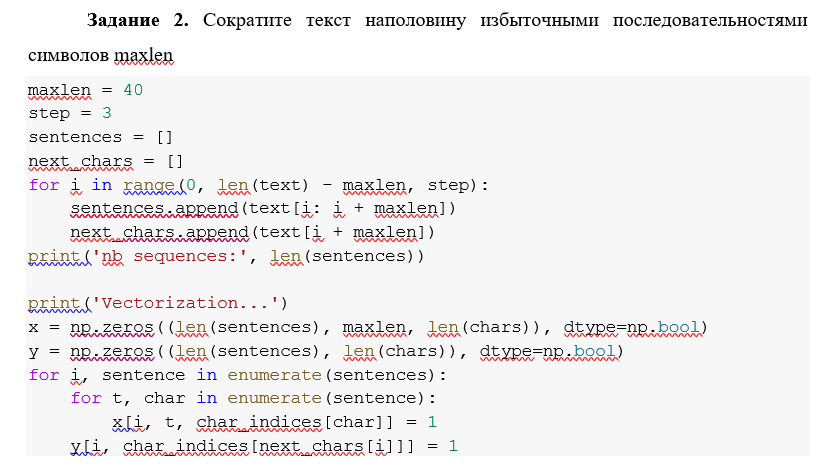
### Задание 2.

In [ ]:
text = nietzsche
chars = dict(zip(unique_symbols, [i for i in range(len(unique_symbols))]))

In [ ]:
def vectorization(text):
  maxlen = 40
  step = 3
  sentences = []
  next_chars = []
  for i in range(0, len(text) - maxlen, step):
      sentences.append(text[i: i + maxlen])
      next_chars.append(text[i + maxlen])
  print('nb sequences:', len(sentences))
  print(sentences[:5])

  print('Vectorization...')
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool_)
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
  for i, sentence in enumerate(sentences):
      for t, char in enumerate(sentence):
          x[i, t, chars[char]] = 1
      y[i, chars[next_chars[i]]] = 1
  return x, y


In [ ]:
X, y = vectorization(nietzsche)
np.unique(X[0][0], return_counts=True)

nb sequences: 200046
['PREFACE. SUPPOSING that Truth is a woman', 'FACE. SUPPOSING that Truth is a woman--w', 'E. SUPPOSING that Truth is a woman--what', 'SUPPOSING that Truth is a woman--what th', 'POSING that Truth is a woman--what then?']
Vectorization...


(array([False,  True]), array([82,  1]))

##### 1.summarization

In [ ]:
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

In [ ]:
## example of summarization
txt = 'There once was a king named Midas who did a good deed for a satyr — a spirit of nature. Dionysus, the god of wine, then granted him a wish. For his wish, Midas asked that whatever he touched would turn to gold. Despite Dionysus’ efforts to prevent it, Midas pleaded that this was a fantastic wish, so it was bestowed. Excited about his newly-earned powers, Midas started touching all kinds of things, turning each item into pure gold. But soon, Midas became hungry. As he picked up a piece of food, he found he couldn’t eat it. It had turned to gold in his hand. Hungry, Midas groaned, “I’ll starve! Perhaps this was not such an excellent wish after all!” Seeing his dismay, Midas’ beloved daughter threw her arms around him to comfort him, and she, too, turned to gold. “The golden touch is no blessing,” Midas cried.'
short_txt = summarize(txt, 0.2)
txt

'There once was a king named Midas who did a good deed for a satyr — a spirit of nature. Dionysus, the god of wine, then granted him a wish. For his wish, Midas asked that whatever he touched would turn to gold. Despite Dionysus’ efforts to prevent it, Midas pleaded that this was a fantastic wish, so it was bestowed. Excited about his newly-earned powers, Midas started touching all kinds of things, turning each item into pure gold. But soon, Midas became hungry. As he picked up a piece of food, he found he couldn’t eat it. It had turned to gold in his hand. Hungry, Midas groaned, “I’ll starve! Perhaps this was not such an excellent wish after all!” Seeing his dismay, Midas’ beloved daughter threw her arms around him to comfort him, and she, too, turned to gold. “The golden touch is no blessing,” Midas cried.'

In [ ]:
short_txt

'Excited about his newly-earned powers, Midas started touching all kinds of things, turning each item into pure gold.Seeing his dismay, Midas’ beloved daughter threw her arms around him to comfort him, and she, too, turned to gold.'

In [ ]:
summarized_n = summarize(nietzsche, 0.5)
summarized_n

'There are the finest gala dresses and disguises for this disease, and that, for instance, most of what places itself nowadays in the show-cases as "objectiveness," "the scientific spirit," "L\'ART POUR L\'ART," and "pure voluntary knowledge," is only decked-out skepticism and paralysis of will--I am ready to answer for this diagnosis of the European disease--The disease of the will is diffused unequally over Europe, it is worst and most varied where civilization has longest prevailed, it decreases according as "the barbarian" still--or again--asserts his claims under the loose drapery of Western culture It is therefore in the France of today, as can be readily disclosed and comprehended, that the will is most infirm, and France, which has always had a masterly aptitude for converting even the portentous crises of its spirit into something charming and seductive, now manifests emphatically its intellectual ascendancy over Europe, by being the school and exhibition of all the charms of 

In [ ]:
X_alt, y_alt = vectorization(summarized_n)

nb sequences: 145768
['There are the finest gala dresses and di', 're are the finest gala dresses and disgu', 'are the finest gala dresses and disguise', ' the finest gala dresses and disguises f', 'e finest gala dresses and disguises for ']
Vectorization...


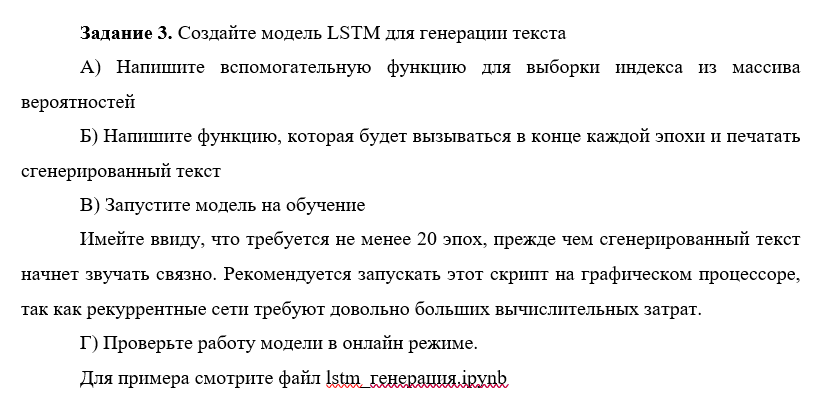
### Задание 3.

In [ ]:
maxlen=40
indices_char = {v: k for k, v in chars.items()}

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)), dropout=0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def on_epoch_end(epoch, logs):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, chars[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.01)

#### Обучение модели

In [ ]:
callbacks = [print_callback, checkpoint, reduce_lr]
history = model.fit(X_alt, y_alt, batch_size=256, epochs=20, callbacks=callbacks)

Epoch 1/20
564/570 [============================>.] - ETA: 0s - loss: 2.8961
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ctive; consequently"... It was pretty mu"
ctive; consequently"... It was pretty mus an the the the in in the the the the the the the in an an te the the the the se an the an an the the an in the in the the the the in the an te an the the e in in the in the an the the the the the the an the the in in an the the the in the in the the the the the in the the the to the the the the the the the on an the the the the the the the the the in the the the the an the the the the an io the 
----- diversity: 0.5
----- Generating with seed: "ctive; consequently"... It was pretty mu"
ctive; consequently"... It was pretty muge ons os ani tt eace soni le th the in tin ies ind the tho the fas ane bes me on e mits se wral io alecas the the f nan oit in the in dich or an in  he is an ind wer an the nie an gin , tan wo s en iile  uas in the whe o

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


568/570 [============================>.] - ETA: 0s - loss: 2.5997
----- Generating text after Epoch: 1
----- diversity: 0.2
----- Generating with seed: "ciated with phlegm in the former and wit"
ciated with phlegm in the former and wit an the the the the whe the the the in in the the the the the and and an the the the the the the the the the the the the the the the the the the the sere the the the the the the the he and the s an the the s re the the the the phe s an the the the the in the the the the sure of the the the the the the an the the in the the the the the the the the the the the the the the the and an on the the the t
----- diversity: 0.5
----- Generating with seed: "ciated with phlegm in the former and wit"
ciated with phlegm in the former and wite tho s ter the the sove  of t an and th and in onl bas the the wens mort the the the the ald wor un the cor the he hont ie tha e the mas se hed on ard the ingt in cer is s tirs hin to the gat ox and ard tha be whar in ho the the th

#### Проверка работоспособности

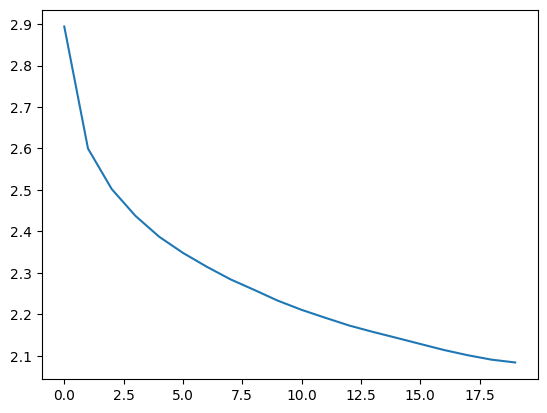

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
def generate_text(length, diversity):
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, chars[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [ ]:
print(generate_text(100, 0.5))

 the purview of self defence and lying for all the soneth of stricime the wonke for expermanted that is the soll and the will men that it a 


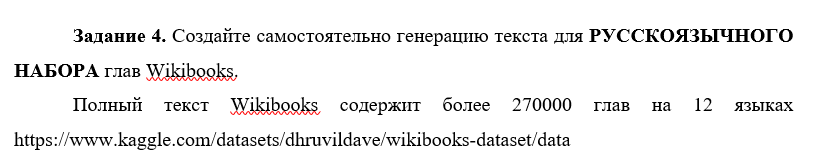
###Задание 4.

####Импорт данных

In [ ]:
 mkdir ~/.kaggle # Создаем папку .kaggle в root

In [ ]:
! cp kaggle.json ~/.kaggle/ # Переносим kaggle.json в рут

In [ ]:
!kaggle datasets download -d dhruvildave/wikibooks-dataset # Скачиваем датасет (зип файлом)

100% 1.82G/1.82G [00:19<00:00, 89.1MB/s]
100% 1.82G/1.82G [00:19<00:00, 102MB/s] 


In [ ]:
!unzip \*.zip  && rm *.zip # Анзипаем

Archive:  wikibooks-dataset.zip
  inflating: wikibooks.sqlite        


In [ ]:
conn = sqlite3.connect('/content/wikibooks.sqlite') # Создаем связь с нашим sqlite файлом
cursor = conn.cursor() # Создаем курсор для запросов
cursor.execute("SELECT * from ru") # Выполняем запросы

raw_ru = cursor.fetchall() # Получаем набор данных от запроса

In [ ]:
cursor.execute(f"PRAGMA table_info(ru);")
column_names = cursor.fetchall()

df_ru = pd.DataFrame(raw_ru, columns=[column[1] for column in column_names]) # Создаем датафрейм из данных и названий столбцов
print(f"Количество строк в датафрейме: {len(df_ru)}\nМаксимальное количество символов в body_text: {df_ru.body_text.str.len().max()}")

Количество строк в датафрейме: 8213
Максимальное количество символов в body_text: 1214800


In [ ]:
df_ru.head()

,title,url,abstract,body_text,body_html
0,Викиучебник: Техника и технология средств масс...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,* [станция|Рабочая станция];,Рабочая станция;\nСервер;\nПерсональный компью...,"<div class=""mw-parser-output""><ul><li><a href=..."
1,Викиучебник: АОН/Пилотское свидетельство,https://ru.wikibooks.org/wiki/%D0%90%D0%9E%D0%...,Гражданское пилотское свидетельство - разрешен...,В Википедии имеется статья по теме «Свидетельс...,"<div class=""mw-parser-output""><div class=""info..."
2,Викиучебник: Книга программиста/Структуры данн...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BD%D0%...,К оглавлению,"К оглавлению\nВсе программы, код которых вылож...","<div class=""mw-parser-output""><p><a href=""/wik..."
3,Викиучебник: Тесты НМО/Гигиенические основы и ...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,Гигиенические основы и медицинский контроль за...,Гигиенические основы и медицинский контроль за...,"<div class=""mw-parser-output""><p><b>Гигиеничес..."
4,Викиучебник: Коктейли/Пенная фея,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Пенная фея,Пенная фея\n\nДжин Old Tom — 60 г\nАбсент — 15...,"<div class=""mw-parser-output""><p><b>Пенная фея..."


####Препроцессинг и анализ данных

In [ ]:
def cleanalyzer(x):

    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^а-яА-Я0-9\.]', ' ', text)
    text = text.split()

    text = [word for word in text]
    text = ' '.join(text)
    text = 'НАЧАЛОПРЕДЛОЖЕНИЯ '+text+' КОНЕЦПРЕДЛОЖЕНИЯ'

    return text

In [ ]:
df_ru['title'] = df_ru['title'].apply(cleanalyzer)

In [ ]:
df_ru

,title,url,abstract,body_text,body_html
0,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,* [станция|Рабочая станция];,Рабочая станция;\nСервер;\nПерсональный компью...,"<div class=""mw-parser-output""><ul><li><a href=..."
1,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник АОН Пилотское св...,https://ru.wikibooks.org/wiki/%D0%90%D0%9E%D0%...,Гражданское пилотское свидетельство - разрешен...,В Википедии имеется статья по теме «Свидетельс...,"<div class=""mw-parser-output""><div class=""info..."
2,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Книга программис...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BD%D0%...,К оглавлению,"К оглавлению\nВсе программы, код которых вылож...","<div class=""mw-parser-output""><p><a href=""/wik..."
3,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Тесты НМО Гигиен...,https://ru.wikibooks.org/wiki/%D0%A2%D0%B5%D1%...,Гигиенические основы и медицинский контроль за...,Гигиенические основы и медицинский контроль за...,"<div class=""mw-parser-output""><p><b>Гигиеничес..."
4,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Пенная ...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Пенная фея,Пенная фея\n\nДжин Old Tom — 60 г\nАбсент — 15...,"<div class=""mw-parser-output""><p><b>Пенная фея..."
...,...,...,...,...,...
8208,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Чики пу...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Чики-пуки,Чики-пуки\n\nджин – 15 мл;\nликер из черной см...,"<div class=""mw-parser-output""><p><b>Чики-пуки<..."
8209,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Будьте ...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Будьте добры,"Будьте добры\nанглийское название: Be Kind, Un...","<div class=""mw-parser-output""><p><b>Будьте доб..."
8210,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Античны...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Античный дайкири,Античный дайкири\nанглийское название: Ancient...,"<div class=""mw-parser-output""><p><b>Античный д..."
8211,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Открытый учебник...,https://ru.wikibooks.org/wiki/%D0%9E%D1%82%D0%...,,,"<div class=""mw-parser-output"">\n<!-- \nNewPP l..."


In [ ]:
# pd состоит из 8213 строк, разбиваем в примерном соотношении на 60:20:20 - итого 5000:1600:1613
train = df_ru.iloc[:5000, :]
val = df_ru.iloc[5000:6600, :].reset_index(drop=True)
test = df_ru.iloc[6600:, :].reset_index(drop=True)

In [ ]:
val.head()

,title,url,abstract,body_text,body_html
0,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Кофейны...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Кофейный,"Кофейный\n\nконьяк 20 мл,\nкофейный ликер 30 м...","<div class=""mw-parser-output""><p><b>Кофейный</..."
1,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Коктейл...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Коктейль с мороженым и коньяком,Коктейль с мороженым и коньяком\n\nконьяк 50 м...,"<div class=""mw-parser-output""><p><b>Коктейль с..."
2,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Коктейли Мятная ...,https://ru.wikibooks.org/wiki/%D0%9A%D0%BE%D0%...,Мятная свежесть,Мятная свежесть\n\nодин из рецептов[править]\n...,"<div class=""mw-parser-output""><p><b>Мятная све..."
3,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Установка Устано...,https://ru.wikibooks.org/wiki/%D0%A3%D1%81%D1%...,Для работы с пакетами в Debian предназначена к...,Для работы с пакетами в Debian предназначена к...,"<div class=""mw-parser-output""><p>Для работы с ..."
4,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Фоторецептурный ...,https://ru.wikibooks.org/wiki/%D0%A4%D0%BE%D1%...,"Пополнитель для Agfa Atomal — состав, добавляю...","Пополнитель для Agfa Atomal — состав, добавляю...","<div class=""mw-parser-output""><p><b>Пополнител..."


In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['title'].tolist())
max_length = max(len(element.split()) for element in train['title'].tolist())

In [ ]:
df_vocab = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word','count'])
df_vocab.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
df_vocab.head()

,word,count
0,викиучебник,5001
1,началопредложения,5000
2,конецпредложения,5000
3,коктейли,2167
4,и,443


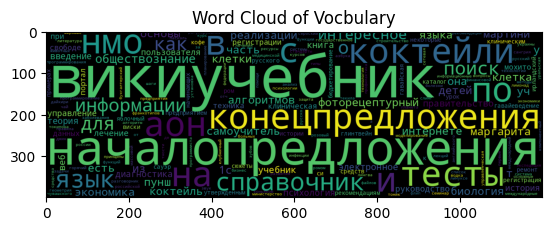

In [ ]:
words = ""
words += " ".join(df_vocab['word'].tolist())+" "
wordcloud = WordCloud(width = 1200, height = 400,
                background_color ='black',
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.title('Word Cloud of Vocbulary')
plt.show()

In [ ]:
df_vocab.describe()

,count
count,6052.000000
mean,5.777264
std,115.370629
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5001.000000


In [ ]:
df_vocab[df_vocab['count']>=50]

,word,count
0,викиучебник,5001
1,началопредложения,5000
2,конецпредложения,5000
3,коктейли,2167
4,и,443
5,тесты,422
6,нмо,420
7,в,341
8,с,278
9,по,132


In [ ]:
vocab_size = len(df_vocab[df_vocab['count']>=50])
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['title'].tolist())

In [ ]:
df_ru['length'] = df_ru['title'].apply(lambda x: len(x.split(' ')))

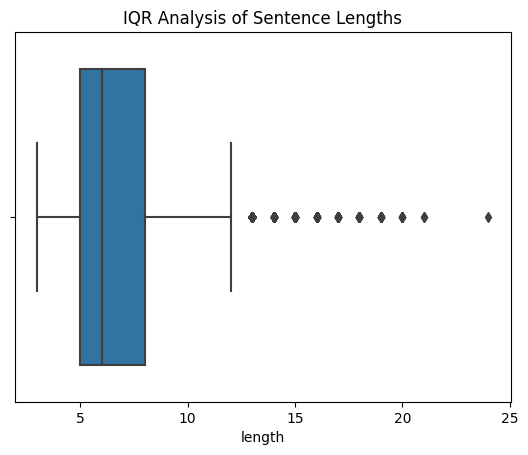

In [ ]:
sns.boxplot(x='length', data=df_ru)
plt.title('IQR Analysis of Sentence Lengths')
plt.show()

In [ ]:
max_length = 20
print(train.loc[0, 'title'])
print(tokenizer.texts_to_sequences([train.loc[0, 'title']])[0])

НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технология средств массовой информации Интернет Техника КОНЕЦПРЕДЛОЖЕНИЯ
[3, 2, 1, 6, 1, 1, 1, 18, 1, 1, 4]


In [ ]:
seq = train.loc[0, 'title'].split()
X, y = [], []
for i in range(1,len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    X.append(' '.join(in_seq))
    y.append(out_seq)

example = pd.DataFrame(columns=['input','output'])
example['input'] = X
example['output'] = y
example

,input,output
0,НАЧАЛОПРЕДЛОЖЕНИЯ,Викиучебник
1,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник,Техника
2,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника,и
3,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и,технология
4,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,средств
5,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,массовой
6,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,информации
7,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,Интернет
8,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,Техника
9,НАЧАЛОПРЕДЛОЖЕНИЯ Викиучебник Техника и технол...,КОНЕЦПРЕДЛОЖЕНИЯ


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, batch_size, tokenizer, vocab_size, max_length, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)
        return X, y

    def __get_data(self,batch):

        X, y = list(), list()
        captions = batch.loc[:, self.X_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            max_len = self.max_length if len(seq) > self.max_length else len(seq)
            for i in range(1,max_len):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X.append(in_seq)
                y.append(out_seq)

        X, y = np.array(X), np.array(y)

        return X, y

In [ ]:
train_gen = CustomDataGenerator(train, 'title', 16, tokenizer, vocab_size, max_length)
val_gen = CustomDataGenerator(val, 'title', 16, tokenizer, vocab_size, max_length)
test_gen = CustomDataGenerator(test, 'title', 16, tokenizer, vocab_size, max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, Reshape,
                                     concatenate, Bidirectional, Dense, Input)

In [ ]:
input_layer = Input(shape=(50,))
x = Embedding(vocab_size, 64)(input_layer)
x = Bidirectional(LSTM(100))(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-0.1*epoch)


lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[checkpoint, es, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
310/312 [============================>.] - ETA: 0s - loss: 1.3229
Epoch 1: val_loss improved from inf to 1.01128, saving model to model.h5
312/312 [==============================] - 11s 18ms/step - loss: 1.3219 - val_loss: 1.0113 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
308/312 [============================>.] - ETA: 0s - loss: 0.9616
Epoch 2: val_loss improved from 1.01128 to 0.89499, saving model to model.h5
312/312 [==============================] - 5s 15ms/step - loss: 0.9620 - val_loss: 0.8950 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
311/312 [============================>.] - ETA: 0s - loss: 0.8933
Epoch 3: val_loss improved from 0.89499 to 0.88339, saving model to model.h5
312/312 [==============================] - 4s 13ms/step - loss: 0.8936 - val_loss: 0.8834 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
306/312 [============================>.] - ETA: 0s - loss: 0.8675
Epoch 4: val_loss improved from 0.88339 to 0.85029, saving model to model.h5
312/312 [==============================] - 4s 11ms/step - loss: 0.8674 - val_loss: 0.8503 - 

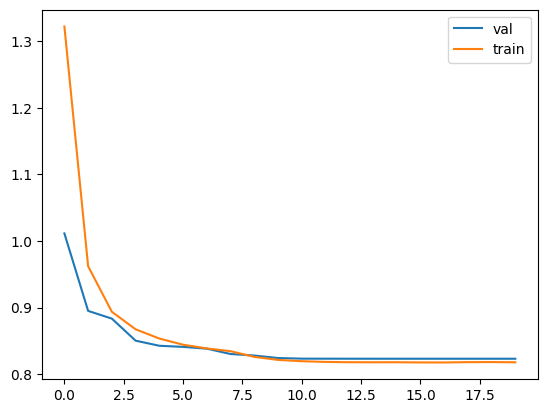

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val', 'train'])
plt.show()